### *ELLIS Summer School Research Challenge*
## Constrained reconstruction of spatiotemporal dynamics with diffusion models

This notebook shows how to use a pretrained diffusion model for generating and reconstructing spatiotemporal dynamics of 2D Navier-Stokes turbulence.

In [1]:
# set the path to your project directory
%cd /ptmp/mp063/constrained-generation/ 
%load_ext autoreload
%autoreload 2

/raven/ptmp/mp063/constrained-generation


In [2]:
import time
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from IPython.display import Image, display

from models.config import read_yaml
import models.xarray_utils as xu
from models.simulation import Simulation, SamplingConfig
from models.guidance import Guidance, Constraint

Defining some helper functions:

In [14]:
def get_masked_data(x: torch.Tensor, mask_prob: float = 0.5) -> torch.Tensor:
    """ Randomly masks input data with NaNs.
    Args:
        x: Tensor to be masked.
        mask_prob: Probability for masking (lower values means more data masked).

    Returns:
        Masked data.
    """
    # mask_2d = (torch.rand(x.shape[1:], device=x.device) < mask_prob)  # shape (H, W)
    # mask_3d = mask_2d.unsqueeze(0).expand_as(x)
    # x_masked = x.clone()
    # x_masked[~mask_3d] = float('nan')
    # return x_masked
    mask = torch.zeros_like(x[0])
    mask[7:22, 7:22] = 1
    mask_3d = mask.unsqueeze(0).expand_as(x).bool()
    x_masked = x.clone()
    x_masked[~mask_3d] = float('nan')
    return x_masked

def plot_time_series(data: torch.Tensor, num_steps: int, title: str = "", vmin:float = -15, vmax: float = 15):
    """ Plots frames from a time series for a given number of steps.
    Args:
        data: Time series tensor of shape [time steps, height, width].
        num_steps: Number of time steps to plot.
        title: Plot title.
        vmin: Minimum value of colormap.
        vmax: Maximum value of colormap.
    """
    plt.figure(figsize=(15,5))
    for i in range(num_steps):
        plt.subplot(1, num_steps, i+1)
        plt.title(f"step {i+1}")
        plt.imshow(data[i], cmap="RdBu", vmin=vmin, vmax=vmax)
        plt.xticks([])
        plt.yticks([])
        if i == 0:
            plt.ylabel(title)
    plt.tight_layout()
    plt.show()

Load the diffusion model and dataset. They are available in the directory: `/ptmp/mp002/ellis/constrained-generation/`

In [4]:
project_path = "/ptmp/mp063/constrained-generation"
scratch_path = "/ptmp/mp002/ellis/constrained-generation"

diffusion_config_path = f"{project_path}/configs/diffusion_vorticity_config.yaml"
config = read_yaml(diffusion_config_path)

# large network and dataset
#config["dataset"]["dataset_path"] = f"{scratch_path}/datasets/vorticity_large_256.nc"
#config["checkpoints"]["inference_ckpt"] = f"{scratch_path}/checkpoints/dm_aq2nib68/best.ckpt"
#noise_shape = (1,1,256,256)

# small netork and dataset
config["dataset"]["dataset_path"] = f"{scratch_path}/datasets/vorticity_small_64.nc"
config["checkpoints"]["inference_ckpt"] = f"{scratch_path}/checkpoints/dm_90sm313k/best.ckpt"
noise_shape = (1,1,64,64)

sim = Simulation(config=config,
                 noise_shape=noise_shape,
                 variable_name="vorticity")

sim.initialize()

Apply a mask to the ground truth data to create dummy observations

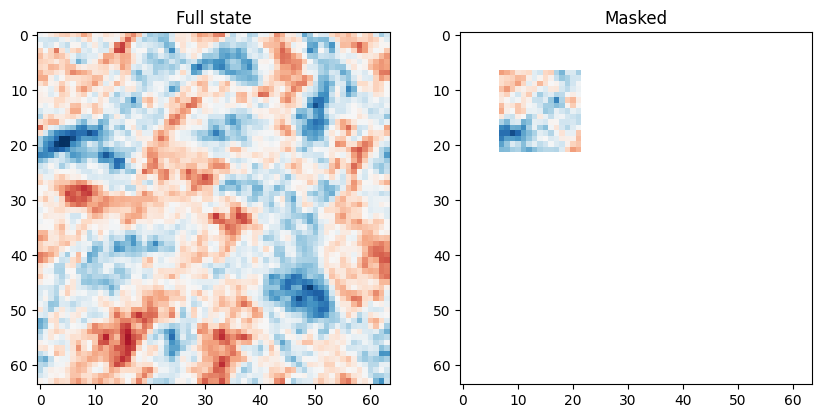

mask shape: torch.Size([50, 64, 64])


In [15]:
num_measurements = 50 # should be set to the length of the generated time series
measurements = torch.from_numpy(sim.target_test[2:num_measurements+2].values) # offset for initial conditions
masked_measurements = get_masked_data(measurements, mask_prob=0.05)

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.title("Full state")
plt.imshow(measurements[0,:,:], vmin=-10, vmax=10, cmap="RdBu")
plt.subplot(1,2,2)
plt.title("Masked")
plt.imshow(masked_measurements[0,:,:], vmin=-10, vmax=10, cmap="RdBu")
plt.show()

print(f"mask shape: {masked_measurements.shape}")

Generate time series using the sparse observations:

In [16]:
constraint = Constraint(measurement=masked_measurements,
                        loss_type="mse",
                        constraint_type="sparse")

sim.inference.guidance = Guidance(constraint=constraint,
                                  gamma=30.0, #strength of the constraint
                                  transforms=sim.transforms)

sampling_config = SamplingConfig(
    use_conditioning=True,
    num_rollout_steps=20, #length of generated time series
    num_diffusion_steps=50, # number of generative steps for image
    show_progress=False
)

results = sim.run(sampling_config)

Sample count:   0%|                                                                                                          | 0/20 [00:00<?, ?it/s]

Sample count: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:30<00:00,  7.52s/it]


Generate time series without observations:

In [17]:
# run inference sampling without guidance

sim = Simulation(config=config,
                 noise_shape=noise_shape,
                 variable_name="vorticity")

sim.initialize()
sim.inference.guidance = None
results_no_guidance = sim.run(sampling_config)

Sample count: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:59<00:00,  2.99s/it]


## Combined Guidances

In [18]:
constraint_sparse = Constraint(measurement=masked_measurements,
                        loss_type="mse",
                        constraint_type="sparse")
constraint_mean = Constraint(measurement=torch.tensor([0.0],device="cuda", dtype=torch.float64).squeeze(), #enforce global mean to be zero
                        loss_type="mse",
                        constraint_type="mean")
constraint = [constraint_sparse, constraint_mean]
sim.inference.guidance = Guidance(constraint=constraint,
                                  gamma=[30.0,4000.0],
                                  transforms=sim.transforms)
results_combined = sim.run(sampling_config)

Sample count:   0%|                                                                                                          | 0/20 [00:00<?, ?it/s]

Sample count: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:19<00:00,  6.99s/it]


In [ ]:
type(results_combined)

xarray.core.dataarray.DataArray

Plot the results:

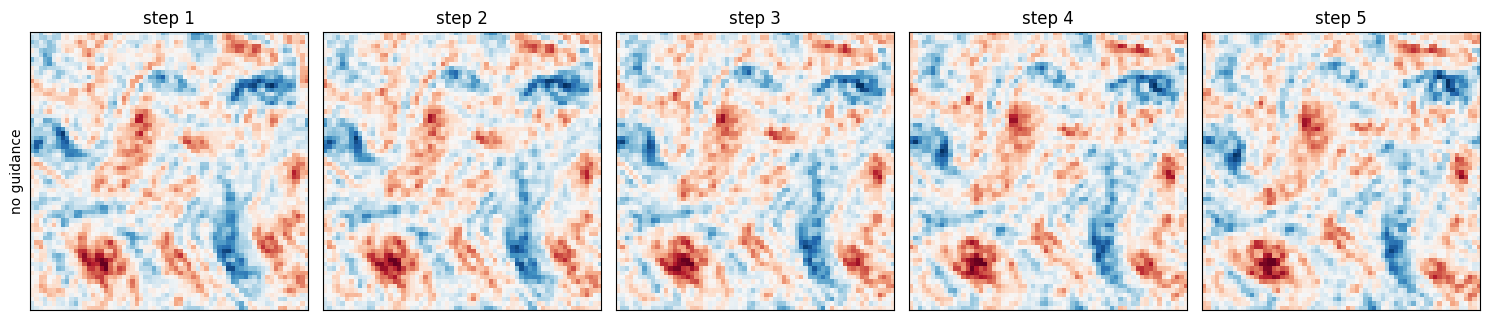

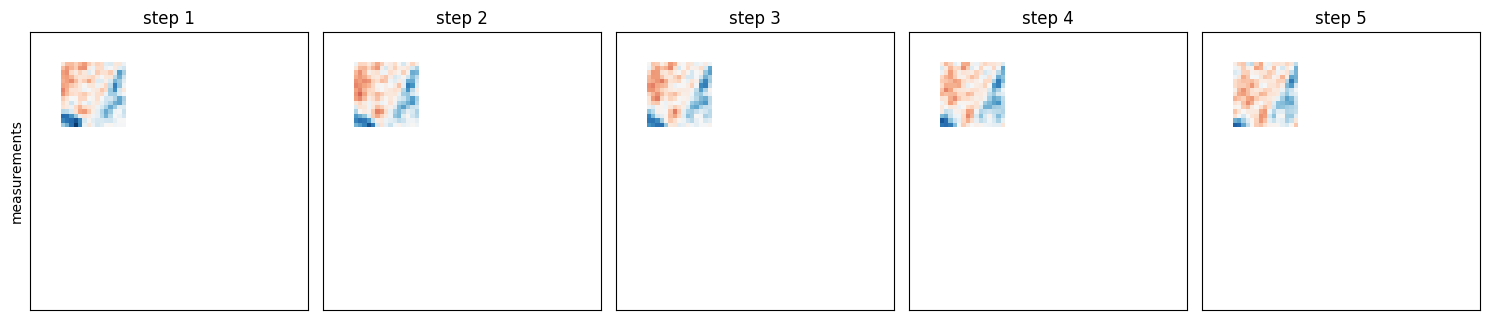

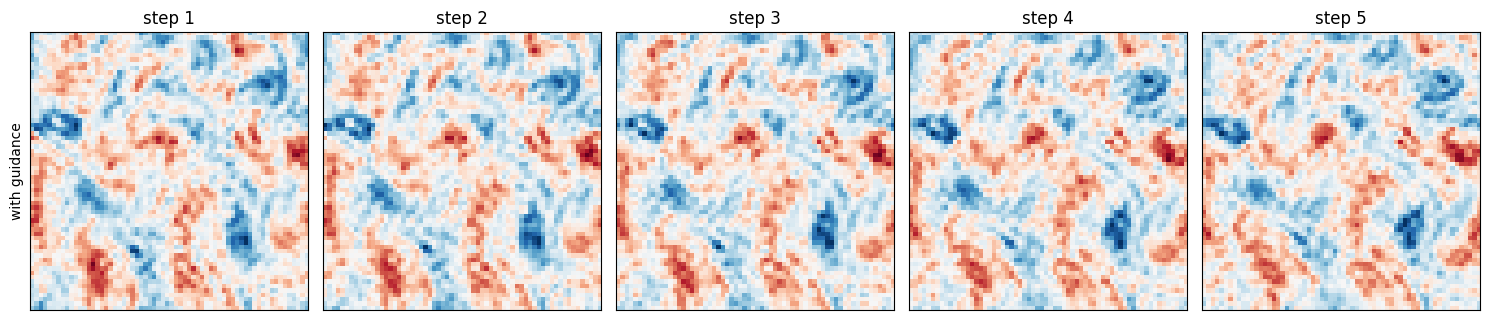

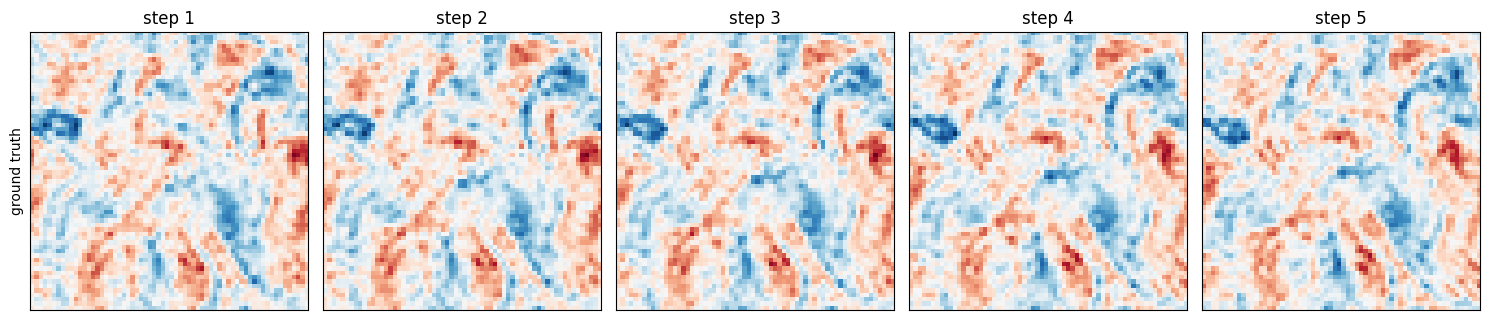

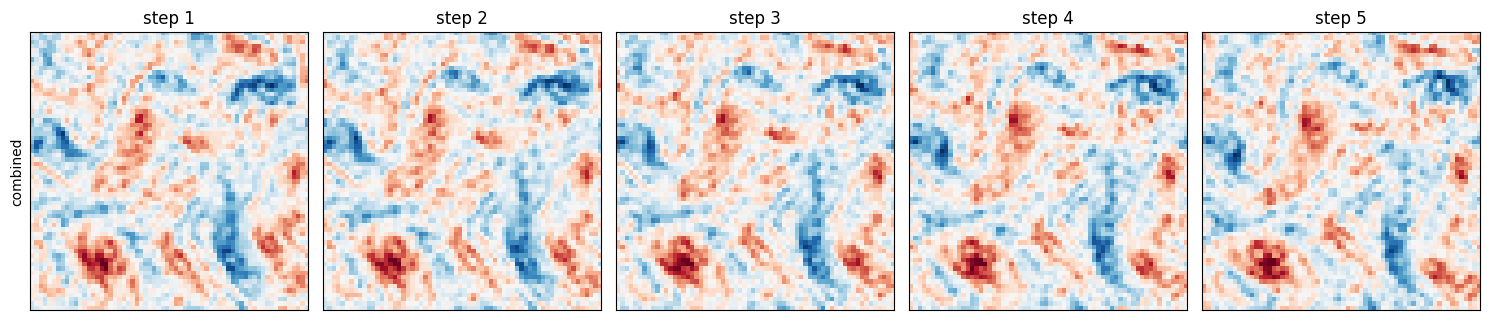

In [19]:
num_steps = 5
start = 10 #start plotting at the 10th time step
w_crop, h_crop = 64, 64 

plot_time_series(results_no_guidance[start:, :h_crop, :w_crop], num_steps=num_steps, title="no guidance", vmin=-10, vmax=10)
plot_time_series(masked_measurements[start:, :h_crop, :w_crop], num_steps=num_steps,  title="measurements", vmin=-10, vmax=10)
plot_time_series(results[start:, :h_crop, :w_crop], num_steps=num_steps,  title="with guidance", vmin=-10, vmax=10)
plot_time_series(sim.target_test[2+start:, :h_crop, :w_crop], num_steps=num_steps, title="ground truth", vmin=-10, vmax=10)
plot_time_series(results_no_guidance[start:, :h_crop, :w_crop], num_steps=num_steps, title="combined", vmin=-10, vmax=10)

### Benchmarking with Metrics

In [23]:
#RMSE
def rmse(results, grnd_truth):
    rmse =np.mean((results-grnd_truth)**2,axis=(1,2))
    np.sqrt(rmse)
    return rmse


In [24]:
rmse_combined = rmse(results_combined,sim.target_test[2+start:,:,:])
rmse_guidance_sparse = rmse(results,sim.target_test[2+start:,:,:])
rmse_guidance_mean = rmse(results_mean,sim.target_test[2+start:,:,:])
rmse_no_guidance = rmse(results_no_guidance,sim.target_test[2+start:,:,:])

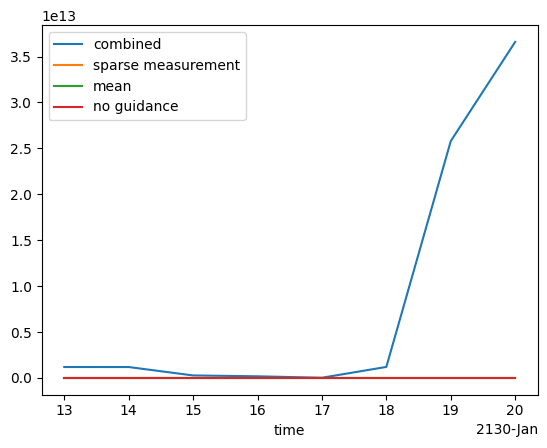

In [25]:
rmse_combined.plot(label="combined")
rmse_guidance_sparse.plot(label="sparse measurement")
rmse_guidance_mean.plot(label="mean")
rmse_no_guidance.plot(label="no guidance")

plt.legend()

Enforcing a global constraint:

In [20]:
project_path = "/ptmp/mp063/constrained-generation"
scratch_path = "/ptmp/mp002/ellis/constrained-generation"

diffusion_config_path = f"{project_path}/configs/diffusion_vorticity_config.yaml"
config = read_yaml(diffusion_config_path)

# large network and dataset
#config["dataset"]["dataset_path"] = f"{scratch_path}/datasets/vorticity_large_256.nc"
#config["checkpoints"]["inference_ckpt"] = f"{scratch_path}/checkpoints/dm_aq2nib68/best.ckpt"
#noise_shape = (1,1,256,256)

# small netork and dataset
config["dataset"]["dataset_path"] = f"{scratch_path}/datasets/vorticity_small_64.nc"
config["checkpoints"]["inference_ckpt"] = f"{scratch_path}/checkpoints/dm_90sm313k/best.ckpt"
noise_shape = (1,1,64,64)

sim = Simulation(
                config=config,
                noise_shape=noise_shape,
                variable_name="vorticity"
)

sim.initialize()

In [21]:
constraint = Constraint(measurement=torch.tensor([0.0],device="cuda", dtype=torch.float64).squeeze(), #enforce global mean to be zero
                        loss_type="mse",
                        constraint_type="mean")

sim.inference.guidance = Guidance(constraint=constraint,
                                  gamma=4000.0,
                                  transforms=sim.transforms)

In [22]:
sampling_config = SamplingConfig(
    use_conditioning = True,
    num_rollout_steps = 20, # length of generated time series
    num_diffusion_steps = 50,
    show_progress = False
)
    
results_mean = sim.run(sampling_config)

Sample count:   0%|                                                                                                          | 0/20 [00:00<?, ?it/s]

Sample count: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:17<00:00,  6.85s/it]


In [26]:
sim.inference.guidance = None

sampling_config = SamplingConfig(
    use_conditioning = True,
    num_rollout_steps = 20,
    num_diffusion_steps = 50,
    show_progress = False
)
    
results_no_constraint = sim.run(sampling_config)

Sample count:   0%|                                                                                                          | 0/20 [00:00<?, ?it/s]

Sample count: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:59<00:00,  2.99s/it]


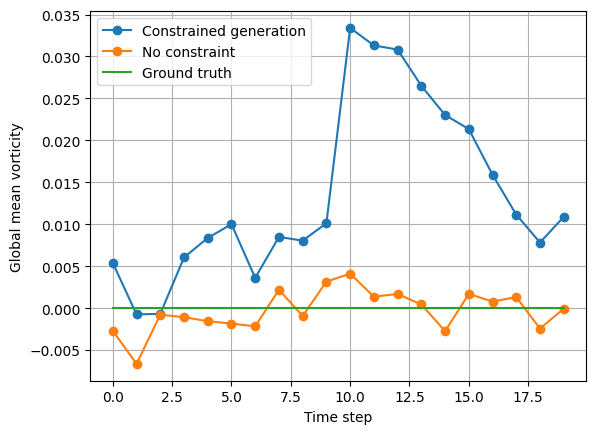

In [27]:
plt.plot(results.mean(dim=("latitude", "longitude")), marker="o", label="Constrained generation")
plt.plot(results_no_constraint.mean(dim=("latitude", "longitude")), marker="o", label="No constraint")
plt.plot(sim.target_test[:len(results)].mean(dim=("latitude", "longitude")), label="Ground truth")
plt.ylabel("Global mean vorticity")
plt.xlabel("Time step")
plt.legend()
plt.grid()

Plot video of the generated dynamics

MovieWriter ffmpeg unavailable; using Pillow instead.


FileNotFoundError: [Errno 2] No such file or directory: '/p'

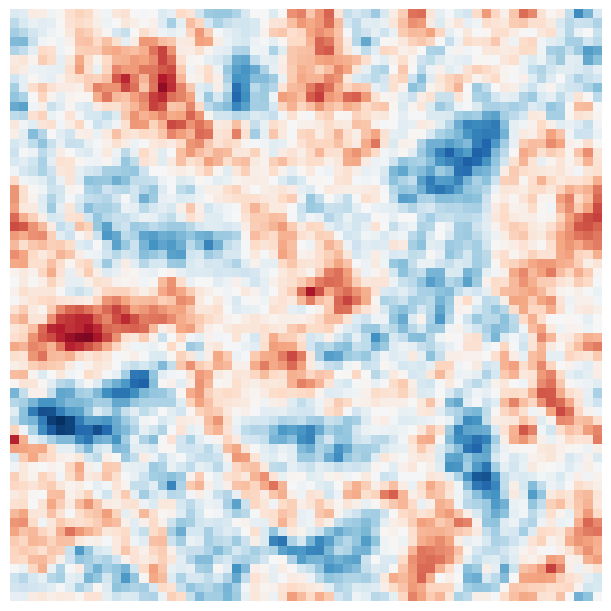

In [28]:
fig, ax = plt.subplots(1,1,figsize=(6, 6), constrained_layout=True)
def update(i):
    cmap='RdBu'
    
    ax.imshow(results[i],vmin=-10, vmax=10, origin='lower', cmap=cmap)
    ax.set_axis_off()
update(1)

num_rollout_steps = sampling_config.num_rollout_steps
output_filename = '/p/tmp/hess/scratch/constrained-generation/results/generated_turbulence_large.gif'
anim = FuncAnimation(fig, update, frames=np.arange(0, num_rollout_steps), interval=250, repeat=False)
anim.save(output_filename, dpi=50)
plt.close()

display(Image(filename=output_filename))